<a href="https://colab.research.google.com/github/hatrg01/GATCLML/blob/main/GATMetricLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
torchversion = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Getting image

In [3]:
!unzip /content/drive/MyDrive/DATA/wangdataset.zip

unzip:  cannot find or open /content/drive/MyDrive/DATA/wangdataset.zip, /content/drive/MyDrive/DATA/wangdataset.zip.zip or /content/drive/MyDrive/DATA/wangdataset.zip.ZIP.


In [4]:
import os
import cv2
def get_img(datadir):
  data =[]
  names = []
  try:
    img_names = os.listdir(datadir)
    for i in img_names:
      imgdir = datadir + i
      try:
        img = cv2.imread(imgdir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (200,200))
        data.append(img)
        names.append(i)
      except AttributeError:
        print('No image')
  except AttributeError:
    print('No folder')
  return data, names

In [5]:
datadir = './wangdataset/Images/'
img_name = os.listdir(datadir)
images, names = get_img(datadir)
len(images), len(names)

FileNotFoundError: [Errno 2] No such file or directory: './wangdataset/Images/'

In [ ]:
categories = ['Africa', 'Beach', 'Ancient Architecture', 'Bus', 'Dinosaur', 'Elephant', 'Flower', 'Horse', 'Mountain', 'Food']
labels = []
for i in names:
  label = int(i[:-4])//100
  labels.append(label)

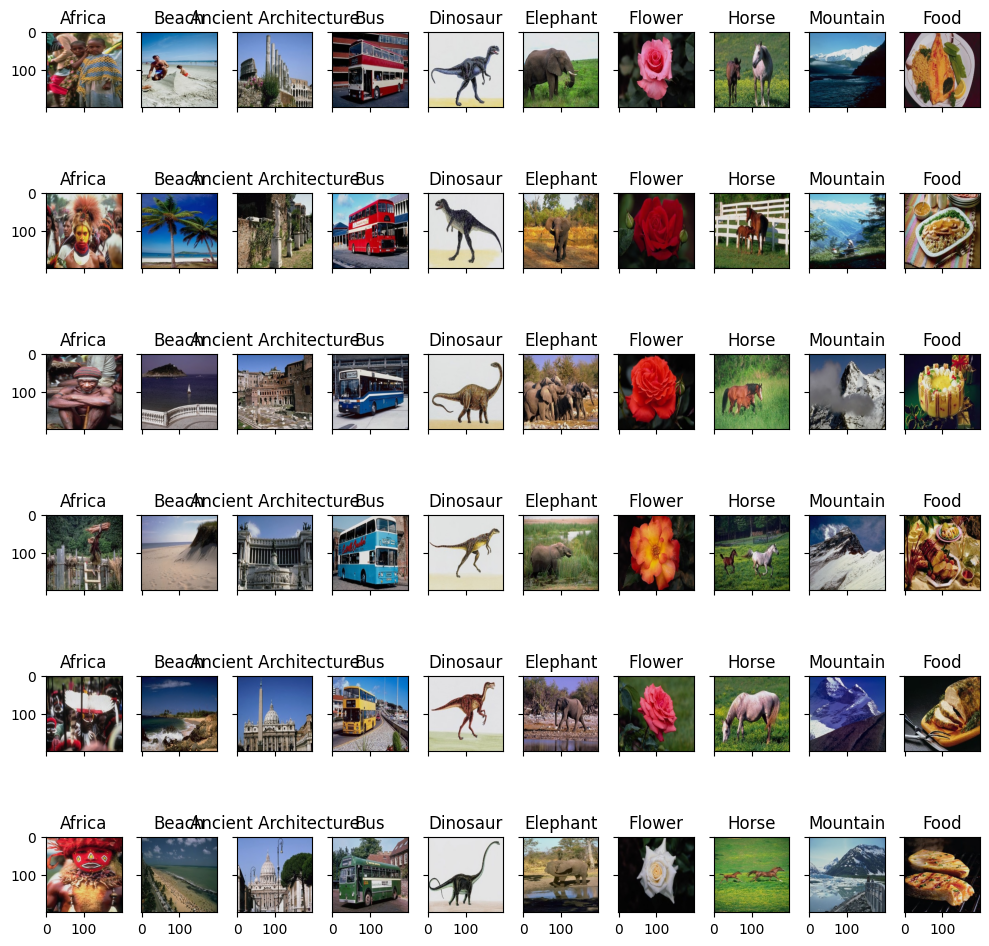

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=6, ncols=10, sharex=True, sharey=True, figsize=(10, 10))
k = 0
for i in range(6):
  for j in range(10):
    name = j * 100 + k
    img = cv2.imread('./wangdataset/Images/' + str(name) + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (200,200))
    ax[i][j].imshow(img)
    ax[i][j].set_title(categories[name//100])
    k += 1
plt.tight_layout()

# Generating graph

In [ ]:
from skimage.measure import regionprops
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.future import graph
def generate_graph(image, n_segments):
  segments = slic(image, n_segments=n_segments, compactness=30)
  g = graph.RAG(segments, connectivity=2)
  props = regionprops(segments, image)
  return segments, g, props

In [ ]:
n_segments = 50
segmentation_slic = []
img_graphs = []
img_props = []
for i in images:
  segments, g, props = generate_graph(i, n_segments)
  segmentation_slic.append(segments)
  img_graphs.append(g)
  img_props.append(props)

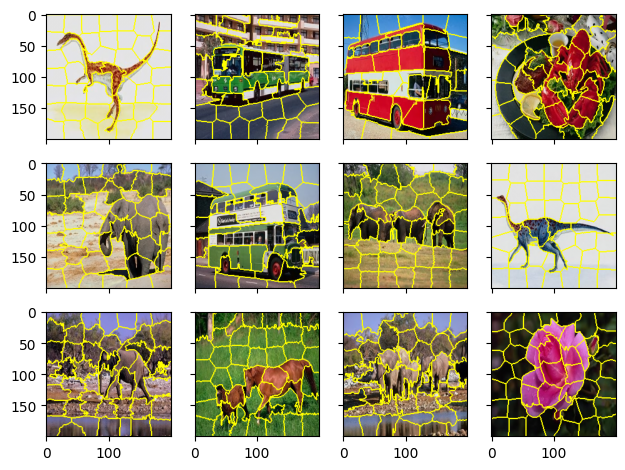

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
ax[0][0].imshow(mark_boundaries(images[547], segmentation_slic[547]))
ax[0][1].imshow(mark_boundaries(images[101], segmentation_slic[101]))
ax[0][2].imshow(mark_boundaries(images[201], segmentation_slic[201]))
ax[0][3].imshow(mark_boundaries(images[311], segmentation_slic[311]))
ax[1][0].imshow(mark_boundaries(images[401], segmentation_slic[401]))
ax[1][1].imshow(mark_boundaries(images[501], segmentation_slic[501]))
ax[1][2].imshow(mark_boundaries(images[601], segmentation_slic[601]))
ax[1][3].imshow(mark_boundaries(images[701], segmentation_slic[701]))
ax[2][0].imshow(mark_boundaries(images[801], segmentation_slic[801]))
ax[2][1].imshow(mark_boundaries(images[901], segmentation_slic[901]))
ax[2][2].imshow(mark_boundaries(images[357], segmentation_slic[357]))
ax[2][3].imshow(mark_boundaries(images[791], segmentation_slic[791]))
plt.tight_layout()

In [ ]:
def encode_edges(g):
  E = [[], []]
  for i, j in g.edges():
    E[0].append(i-1)
    E[0].append(j-1)
    E[1].append(j-1)
    E[1].append(i-1)
  return E

In [ ]:
edges = []
for i in range(len(img_graphs)):
  edge_index = encode_edges(img_graphs[i])
  edges.append(edge_index)
len(edges)

In [ ]:
import numpy as np
def feature_extraction(segmentation, image):
  NUM_FEATURES = 97
  props = regionprops(segmentation, image)
  features = np.zeros((max(np.unique(segmentation)), NUM_FEATURES), dtype=np.float32)

  for i, prop in enumerate(props):
    features[i][0:16] = prop['moments'].flatten()

    bbox = prop['bbox']
    features[i][16] = bbox[2] - bbox[0]
    features[i][17] = bbox[3] - bbox[1]

    features[i][18] = prop['area_convex']
    features[i][19] = prop['perimeter']

    features[i][20:23] = prop['intensity_mean']
    features[i][23:26] = prop['intensity_max']
    features[i][26:29] = prop['intensity_min']

    features[i][29:31] = prop['centroid_local']
    features[i][31:37] = prop['centroid_weighted_local'].flatten()

    features[i][37] = prop['orientation']
    features[i][38] = prop['feret_diameter_max']
    features[i][39] = prop['extent']
    features[i][40] = prop['solidity']

    features[i][41:89] = prop['moments_weighted_central'].flatten()
    features[i][89:96] = prop['moments_hu'].flatten()
    features[i][96] = prop['perimeter_crofton']

  return features

In [ ]:
max(segmentation_slic[3].reshape(-1))

53

In [6]:
node_features = []
for i in range(len(images)):
  feature = feature_extraction(segmentation_slic[i], images[i])
  node_features.append(feature)

NameError: name 'images' is not defined

In [ ]:
# import json
# def dumps_json(output_file ,names, node_features, edges, labels):
#     t = []
#     for i in range(len(node_features)):
#         d = {'name':names[i], 'node': node_features[i].tolist(), 'edge': edges[i], 'label': labels[i]}
#         t.append(d)
#     with open(output_file, 'w') as output:
#         output.write(json.dumps(t))

In [ ]:
# dumps_json('/content/drive/MyDrive/DATN/wangdataset_graph_features.json', names, node_features, edges, labels)

In [19]:
from torch_geometric.data import Data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def prepare_data(node_features, edges, label):
  x = torch.tensor(node_features)
  edge_index = torch.tensor(edges, dtype=torch.long)
  d = Data(x=x, edge_index=edge_index, y=label)
  return d

In [20]:
D = []
for i in range(len(node_features)):
  d = prepare_data(node_features[i], edges[i], labels[i])
  D.append(d)
len(D), D[0].x.size(),  D[0].edge_index.size(), D[0].x.dtype

(1000, torch.Size([52, 97]), torch.Size([2, 262]), torch.float32)

# Training model

In [21]:
import torch
from torch_geometric.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, data_list):
    super().__init__()
    self.data_list = data_list

  def len(self):
    return len(self.data_list)

  def get(self, idx):
    return self.data_list[idx]

batch_size = 64
dataset = CustomDataset(D)
dataset.shuffle()

train_dataset = dataset[:800]
test_dataset = dataset[800:]

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for step, data in enumerate(train_dataloader):
  print(f'Step {step + 1}:')
  print('=======')
  print(f'Number of graphs in the current batch: {data.num_graphs}')
  print(data)
  print()


Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[3186, 97], edge_index=[2, 15670], y=[64], batch=[3186], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[3196, 97], edge_index=[2, 15736], y=[64], batch=[3196], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[3180, 97], edge_index=[2, 15618], y=[64], batch=[3180], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[3116, 97], edge_index=[2, 15260], y=[64], batch=[3116], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[3204, 97], edge_index=[2, 15818], y=[64], batch=[3204], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[3206, 97], edge_index=[2, 15848], y=[64], batch=[3206], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[3211, 97], edge_index=[2, 15822], y=[64], batch=[3211], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[3230, 97], edge_index=[2, 1

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

class CenterLoss(nn.Module):
  def __init__(self, num_classes, feat_dim, alpha=0.5):
    super(CenterLoss, self).__init__()
    self.num_classes = num_classes
    self.feat_dim = feat_dim
    self.alpha = alpha
    self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

  def forward(self, x, labels):
    unique_labels = torch.unique(labels)
    for label in unique_labels:
      mask = labels == label
      class_embeddings = x[mask]
      center = torch.mean(class_embeddings, dim=0)
      new_centers = self.centers.clone()
      new_centers[label] = center
      self.centers = nn.Parameter(new_centers)

    centers_batch = torch.index_select(torch.tensor(self.centers), dim=0, index=labels)
    center_loss = torch.mean(torch.norm(x - centers_batch, p=2, dim=1))
    return self.alpha * center_loss

class GATMetricLearningNetwork(nn.Module):
  def __init__(self, in_features, hidden_dim, out_features, num_classes, num_heads, concat=True, dropout=0.2):
    super(GATMetricLearningNetwork, self).__init__()

    # self.GAT1 = GATv2Conv(in_features, hidden_dim, heads=num_heads, concat=True, dropout=dropout)

    # self.GAT2 = GATv2Conv(num_heads * hidden_dim, hidden_dim, heads=num_heads, concat=True, dropout=dropout)

    # self.GAT3 = GATv2Conv(num_heads * hidden_dim, hidden_dim, heads=1, concat=False)

    # self.global_pool = global_max_pool(hidden_dim, batch=None)

    self.gat = nn.Sequential(
      GATv2Conv(in_features, hidden_dim, heads=num_heads, concat=True, dropout=dropout),
      # nn.ELU(),
      GATv2Conv(num_heads * hidden_dim, hidden_dim, heads=num_heads, concat=True, dropout=dropout),
      # nn.ELU(),
      GATv2Conv(num_heads * hidden_dim, hidden_dim, heads=1, concat=False)
    )

    self.metric_learning = nn.Sequential(
      nn.Linear(hidden_dim, 512),
      nn.ELU(),
      nn.Dropout(dropout),
      # nn.Linear(1024, 256),
      # nn.ELU(),
      # nn.Dropout(dropout),
      nn.Linear(512, out_features),
      nn.ELU()
    )

    self.classifier = nn.Linear(out_features, num_classes)

  def forward(self, x, edge_index, batch):
    # h = self.GAT1(x, edge_index)
    # h = F.elu(h)
    # h = self.GAT2(h, edge_index)
    # h = F.elu(h)
    # h = self.GAT3(h, edge_index)
    # h = self.gat(x, edge_index)
    for layer in self.gat:
      x = layer(x, edge_index)
      x = F.elu(x)
    h = global_max_pool(x, batch=batch)
    embedding = self.metric_learning(h.view(h.size(0), -1))
    logits = self.classifier(embedding)
    return embedding, logits


in_features = 97
hidden_dim = 128
out_features = 64
num_classes = 10
num_heads = 8
learning_rate = 0.001
alpha = 0.5
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GATMetricLearningNetwork(in_features=in_features, hidden_dim=hidden_dim, out_features=out_features, num_classes=num_classes, num_heads=num_heads)

model.to(device)

cross_entropy_loss = nn.CrossEntropyLoss()
center_loss = CenterLoss(num_classes, out_features)

optimizer = torch.optim.Adam([
  {'params': model.gat.parameters()},
  {'params': model.metric_learning.parameters()},
  {'params': model.classifier.parameters()},
  {'params': center_loss.parameters(), 'lr': 0.005}],
  lr=learning_rate
)


# def train(model, train_loader, valid_data, valid_labels, cross_entropy_loss, center_loss, optimizer, device):
def train(model, train_loader, cross_entropy_loss, center_loss, optimizer, device):
  model.train()
  total_loss = 0.0
  train_correct = 0
  train_total = 0
  # valid_correct = 0
  # valid_total = 0

  for data in train_loader:
    # data = data.to(device)
    labels = data.y
    optimizer.zero_grad()

    features, logits = model(data.x, data.edge_index, data.batch)
    total_cross_entropy_loss = cross_entropy_loss(logits, labels)
    total_center_loss = center_loss(features, labels)

    total_loss = total_cross_entropy_loss + total_center_loss

    total_loss.backward()
    optimizer.step()

    _, train_predicted = torch.max(logits, 1)
    train_total += labels.size(0)
    train_correct += (train_predicted == labels).sum().item()

  train_accuracy = train_correct / train_total

  return total_loss, train_accuracy

for epoch in range(num_epochs):
  total_loss, train_accuracy = train(model, train_dataloader, cross_entropy_loss, center_loss, optimizer, device)
  print(f"Epoch {epoch + 1}/{num_epochs} => "
        # f"Cross Entropy Loss: {cross_entropy_loss:.4f}, "
        # f"Center Loss: {center_loss:.4f}, "
        f"Total Loss: {total_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.4f}")

ModuleNotFoundError: No module named 'torch_geometric'